# 4DSTEM Monte Carlo study

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from matplotlib.colors import LogNorm


import sys
sys.path.insert(0,'..')
from gausscount import counting
from gausscount import profile

from scipy.stats import multivariate_normal

In [2]:
np.empty([0,2,2])

array([], shape=(0, 2, 2), dtype=float64)

In [26]:
def downsample_2x2(array):
    """
    Downsample a 2D array by averaging each 2x2 square of pixels into 1 pixel.
    
    Args:
    - array (np.ndarray): 2D array to be downsampled.
    
    Returns:
    - np.ndarray: Downsampled 2D array.
    """
    new_shape = (array.shape[0] // 2, array.shape[1] // 2)
    downsampled_array = array[:new_shape[0]*2, :new_shape[1]*2].reshape(new_shape[0], 2, new_shape[1], 2).mean(axis=(1, 3))
    return downsampled_array

def extract_electron_pattern(df, evt, center_row=50, center_col=50, window_size=101):
    half_window = window_size // 2
    pattern_df = df[df.event == evt]
    pattern_df = pattern_df[(pattern_df['row'].between(center_row - half_window, center_row + half_window)) &
                    (pattern_df['col'].between(center_col - half_window, center_col + half_window))]
    
    electron_pattern = np.zeros((window_size, window_size), dtype=int)
    for _, hit in pattern_df.iterrows():
        electron_pattern[hit['row'] - (center_row - half_window),
                         hit['col'] - (center_col - half_window)] += hit['counts']
    return electron_pattern

def generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes, frame_size, output_filename, baseline=20, noise_sigma=1, mc_scale=1):
    """
    Generates Monte Carlo frames based on hit positions and multiplicities for each frame, adds baseline and noise, 
    and saves them in an HDF5 file. Also saves the Monte Carlo "truth" data. Note that the frames are first generated
    on a grid 2x larger in x and y and then downsampled 2x2 to reduce the pixel size.
    
    Args:
    - hit_positions_per_frame (list of list of tuples): List of hit positions for each frame. 
        Each element is a list of (x, y) tuples for the corresponding frame.
    - multiplicities_per_frame (list of list of ints): List of multiplicities for each frame. 
        Each element is a list of multiplicities corresponding to the hit positions in the same frame.
    - df (DataFrame): DataFrame containing electron patterns.
    - nframes (int): Number of frames to generate.
    - frame_size (int): Size of each frame (e.g., 576 for 576x576 frames).
    - output_filename (str): Name of the output HDF5 file.
    - baseline (int or float): Baseline value to be added to each pixel in the frames.
    - noise_sigma (float): Standard deviation of the Gaussian noise to be added (mean = 0).
    - mc_scale (float): Scale factor to apply to MC pixel amplitudes.
    
    Returns:
    - None: Saves the generated frames and the Monte Carlo "truth" in the specified HDF5 file.
    """
    
    # Initialize an empty array to store the generated frames and the Monte Carlo truth
    frames = np.zeros((nframes, frame_size*2, frame_size*2), dtype=np.uint32)
    mc_truth = np.zeros((nframes, frame_size*2, frame_size*2), dtype=np.uint32)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    for i in range(nframes):
        hit_positions = hit_positions_per_frame[i]
        multiplicities = multiplicities_per_frame[i]
        
        for (x, y), multiplicity in zip(hit_positions, multiplicities):
            
            for ielec in range(multiplicity):
                
                # Randomly select an event to get the electron pattern
                evt = random.choice(unique_events)
                electron_pattern = extract_electron_pattern(df, evt)

                # Determine the position of the top-left corner where the electron pattern will be positioned
                half_window = len(electron_pattern) // 2
                top_left_x = x - half_window
                top_left_y = y - half_window

                # Calculate the bounds of the pattern slice within the frame
                start_i = max(0, -top_left_x)
                start_j = max(0, -top_left_y)
                end_i = min(frame_size*2 - top_left_x, len(electron_pattern))
                end_j = min(frame_size*2 - top_left_y, len(electron_pattern))

                # Calculate the frame slice where the pattern will be added
                frame_slice_x_start = max(0, top_left_x)
                frame_slice_y_start = max(0, top_left_y)
                frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
                frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

                # Add the electron pattern slice to the current frame
                frames[i, frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
                    (electron_pattern[start_i:end_i, start_j:end_j]*mc_scale).astype(np.uint32)
                
                # Update the Monte Carlo "truth" frame only at the exact hit location
                mc_truth[i, x, y] += np.uint32(1)
    
    # Add baseline and noise to the frames
    frames = frames + baseline
    noise = np.random.normal(0, noise_sigma, frames.shape)
    frames = frames + noise
    #frames = np.clip(frames + noise, 0, 65535).astype(np.uint32)  # Ensure values stay within uint32 range
    
    # Downsample both frames and mc_truth arrays by 2x2
    downsampled_frames = np.zeros((nframes, frame_size, frame_size), dtype=np.float32)
    downsampled_mc_truth = np.zeros((nframes, frame_size, frame_size), dtype=np.uint32)
    
    for i in range(nframes):
        downsampled_frames[i] = downsample_2x2(frames[i])
        downsampled_mc_truth[i] = downsample_2x2(mc_truth[i])*4
    
    # Save the frames and Monte Carlo "truth" in an HDF5 file
    with h5py.File(output_filename, 'w') as h5file:
        h5file.create_dataset('/stem/images', data=np.empty([0, nframes, 1]).astype('uint64'), compression="gzip")
        h5file.create_dataset('/frames', data=downsampled_frames, compression="gzip")
        h5file.create_dataset('/truth', data=downsampled_mc_truth, compression="gzip")
        
# Function to load the data and plot a frame alongside the MC truth with zoom options
def plot_frame_and_mc_truth(hdf5_filename, frame_index=0, x_range=None, y_range=None):
    """
    Load and plot a specific frame alongside the Monte Carlo truth from the HDF5 file with optional zoom.
    
    Args:
    - hdf5_filename (str): The path to the HDF5 file.
    - frame_index (int): The index of the frame to plot.
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the plots.
    """
    # Open the HDF5 file
    with h5py.File(hdf5_filename, 'r') as h5file:
        # Load the specific frame
        frame = h5file['/frames'][frame_index]
        
        # Load the Monte Carlo truth
        mc_truth = h5file['/truth'][frame_index]
        #mc_truth = np.zeros([101,101])
    
    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame.shape[1])
    if y_range is None:
        y_range = (0, frame.shape[0])
    
    # Apply zoom
    frame_zoomed = frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    mc_truth_zoomed = mc_truth[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot the frame and the Monte Carlo truth
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the zoomed frame
    im0 = axs[0].imshow(frame_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Frame {frame_index} (Zoomed)')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Plot the zoomed Monte Carlo truth
    im1 = axs[1].imshow(mc_truth_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title('Monte Carlo Truth (Zoomed)')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    plt.show()

# Function to convert linear indices to 2D (row, col) indices
def linear_to_2d_indices(linear_indices, cols):
    rows = linear_indices // cols
    cols = linear_indices % cols
    return rows, cols

# Function to create a 2D image from the counted frame data
def create_counted_image(frame_data, frame_height, frame_width, weight_data = None):
    # Initialize a 2D array with zeros
    image = np.zeros((frame_height, frame_width), dtype=np.int32)

    # Convert linear indices to 2D indices
    rows, cols = linear_to_2d_indices(frame_data, frame_width)

    # Set the hit pixels
    if(not(weight_data) is None):
        for r,c,w in zip(rows,cols,weight_data):
            image[r, c] = w
    else:
        image[rows,cols] = 1

    return image

def plot_counted_vs_mc_truth(raw_file, counted_file, frame_index=0, x_range=None, y_range=None, weights=False):
    """
    Load and plot a specific raw frame, counted frame, and Monte Carlo truth with optional zoom.
    
    Args:
    - raw_file (str): The path to the raw HDF5 file containing the raw frames and Monte Carlo truth.
    - counted_file (str): The path to the HDF5 file containing the counted results.
    - frame_index (int): The index of the frame to plot.
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    - weights (bool): Whether to use weights from the counted data (default: False).
    
    Returns:
    - None: Displays the plots.
    """
    # Load the raw frame and Monte Carlo truth for the selected frame
    with h5py.File(raw_file, 'r') as h5file:
        raw_frame = h5file['/frames'][frame_index]
        mc_truth_frame = h5file['/truth'][frame_index]
    
    # Load the counted data for the selected frame
    with h5py.File(counted_file, 'r') as h5file:
        frame_data = np.array(h5file['electron_events']['frames'][frame_index])
        weight_data = None
        if weights:
            weight_data = np.array(h5file['electron_events']['weights'][frame_index])
        
        # Convert the counted data into a 2D image
        frame_height = frame_width = mc_truth_frame.shape[0]
        counted_image = create_counted_image(frame_data, frame_height, frame_width, weight_data)
    
    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame_width)
    if y_range is None:
        y_range = (0, frame_height)
    
    # Apply zoom
    counted_image_zoomed = counted_image[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    mc_truth_zoomed = mc_truth_frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    raw_frame_zoomed = raw_frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot the raw frame, counted data, and Monte Carlo truth
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    # Plot the zoomed raw frame
    im0 = axs[0].imshow(raw_frame_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Raw Frame {frame_index}')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Plot the zoomed counted data
    im1 = axs[1].imshow(counted_image_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title(f'Counted Frame {frame_index} ({np.sum(counted_image)} counts)')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    # Plot the zoomed Monte Carlo truth
    im2 = axs[2].imshow(mc_truth_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[2].set_title(f'Monte Carlo Truth ({np.sum(mc_truth_frame)} counts)')
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], orientation='vertical')
    
    plt.show()
    
def plot_example_electron_patterns(df, num_start=0, num_examples=5, window_size=101, mc_scale=1, cmap='magma', downsample=False):
    fig, axes = plt.subplots(2, int(num_examples/2), figsize=(num_examples * 1.5, 5))  # Create a row of subplots
    axs = axes.flatten()

    # Get unique event numbers
    unique_events = df['event'].unique()

    # Randomly select a few events
    selected_events = unique_events[num_start:num_start+num_examples] #np.random.choice(unique_events, size=num_examples, replace=False)

    for i, evt in enumerate(selected_events):
        # Extract the electron pattern for each event
        electron_pattern = extract_electron_pattern(df, evt, window_size=window_size)*mc_scale
        
        if(downsample):
            electron_pattern = downsample_2x2(electron_pattern)

        # Plot the electron pattern
        ax = axs[i]
        im = ax.imshow(electron_pattern, cmap=cmap, origin='lower', extent=[0, window_size, 0, window_size])
        #ax.set_title(f"Event {evt}")
        ax.set_xlabel('x',fontsize=14)
        ax.set_ylabel('y',fontsize=14)
        fig.colorbar(im, ax=ax)  # Add colorbar to each plot
    
    plt.tight_layout()
    
    fname = "example_electron_patterns.pdf"
    if(downsample): fname = "example_electron_patterns_downsampled.pdf"
    plt.savefig(fname)
    
def plot_landau_distribution(df, num_start=0, num_examples=1000, window_size=101, mc_scale=1, downsample=False):
    """
    Plots the Landau distribution of the sum of electron hit energies (i.e., the sum of pixel values for each hit pattern).
    
    Args:
    - df: DataFrame containing electron hit patterns.
    - num_start: Index to start selecting events from the DataFrame.
    - num_examples: Number of electron hit patterns to use in the Landau distribution.
    - window_size: The size of the window for each electron hit pattern.
    - mc_scale: Scale factor for the Monte Carlo counts.
    - downsample: Whether to downsample the electron hit patterns.
    
    Returns:
    - None: Displays the histogram of the Landau distribution.
    """
    # Get unique event numbers
    unique_events = df['event'].unique()

    # Select the desired number of events
    selected_events = unique_events[num_start:num_start + num_examples]

    # Initialize a list to store the sum of pixel energies for each hit pattern
    energy_sums = []

    for evt in selected_events:
        # Extract the electron pattern for each event
        electron_pattern = extract_electron_pattern(df, evt, window_size=window_size) * mc_scale
        
        if downsample:
            electron_pattern = downsample_2x2(electron_pattern)

        # Compute the sum of pixel values (energy sum) for the event
        energy_sum = np.max(electron_pattern)
        energy_sums.append(energy_sum)

    # Plot the histogram of the energy sums (Landau distribution)
    plt.figure(figsize=(8, 6))
    plt.hist(energy_sums, bins=50, color='blue', alpha=0.7, range=[0,100])
    plt.xlabel('Max pixel charge', fontsize=14)
    plt.ylabel('Counts/bin', fontsize=14)
    #plt.title('Landau Distribution of Electron Hit Energies', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    fname = "landau_distribution.pdf"
    if downsample:
        fname = "landau_distribution_downsampled.pdf"
    plt.savefig(fname)

    plt.show()

### Experiment: counting evaluation on MC data

In [27]:
frame_size = 51
baseline = 20
th_single_elec = 10
noise_sigma = 1
mc_scale = 0.2 #0.0265

# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

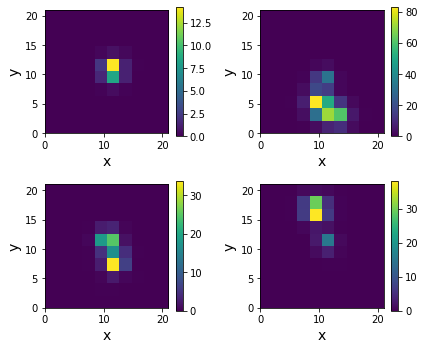

In [28]:
# Plot a few example electron patterns
plot_example_electron_patterns(df, num_start=5, num_examples=4, window_size=21, mc_scale=mc_scale, cmap='viridis', downsample=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


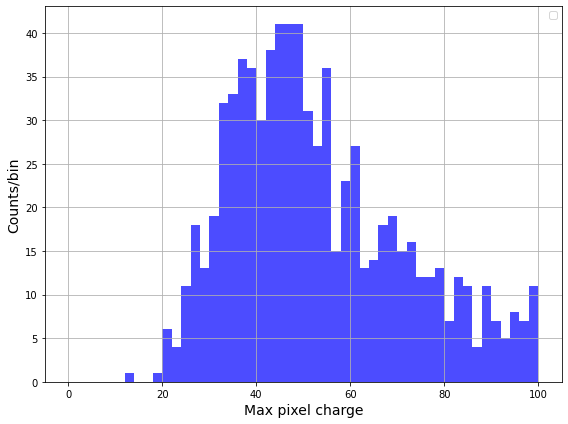

In [29]:
# Plot the Landau of the Monte Carlo events
plot_landau_distribution(df, num_start=0, num_examples=1000, window_size=21, mc_scale=mc_scale, downsample=False)

##### 1. Evaluate a sparse frame to get the Gaussian profile

In [30]:
profile_scan_file = 'sparse_frames.h5'

# Parameters
average_occupancy_sparse = 0.001  # ~0.001 hits per pixel, so ~10 electrons per frame
nframes_sparse = 1000

In [31]:
# Generate hit positions for sparse frames
#np.random.seed(42)
total_pixels = frame_size * frame_size
total_hits_sparse = int(nframes_sparse * total_pixels * average_occupancy_sparse)

# Randomly generate hit positions and their frame indices
hit_positions_sparse = np.random.randint(0, frame_size*2, size=(total_hits_sparse, 2))
frame_indices_sparse = np.random.randint(0, nframes_sparse, size=total_hits_sparse)

# Convert to a list of frame-specific hit positions
hit_positions_per_frame_sparse = [[] for _ in range(nframes_sparse)]
for pos, frame_idx in zip(hit_positions_sparse, frame_indices_sparse):
    hit_positions_per_frame_sparse[frame_idx].append(tuple(pos))

# Multiplicities (all 1 for sparse hits)
multiplicities_per_frame_sparse = []
for hits in hit_positions_per_frame_sparse:
    multiplicities = []
    for i in range(len(hits)):
        multiplicities.append(1)
    multiplicities_per_frame_sparse.append(multiplicities)

# Save the generated sparse frames
generate_and_save_frames(hit_positions_per_frame_sparse, multiplicities_per_frame_sparse, df, 
                         nframes_sparse, frame_size, output_filename=profile_scan_file, 
                         baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

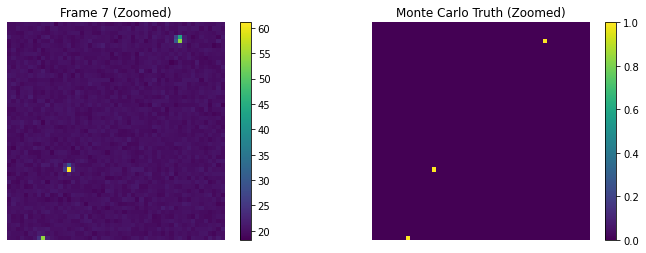

In [32]:
plot_frame_and_mc_truth('sparse_frames.h5', frame_index=7)#, x_range=[30,60], y_range=[30,60])
#plot_frame_and_mc_truth('sparse_frames.h5', frame_index=4)
#plot_frame_and_mc_truth('frames_occupancy_1.h5', frame_index=3, x_range=[30,40], y_range=[30,40])
#plot_frame_and_mc_truth('/Volumes/nvme/lbl/emdata/raw/data_scan0000001531.h5', frame_index=5, x_range=[30,40], y_range=[30,40])

Processing scan at sparse_frames.h5...


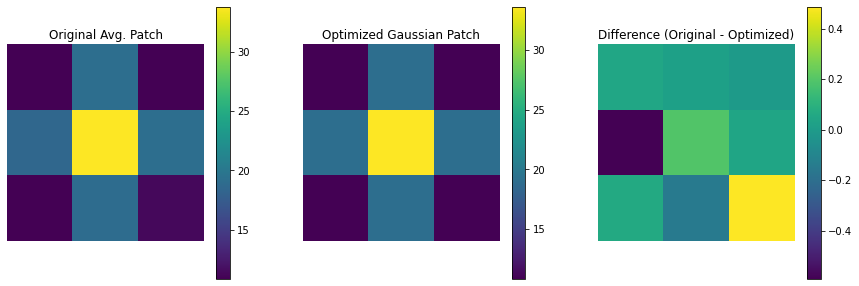

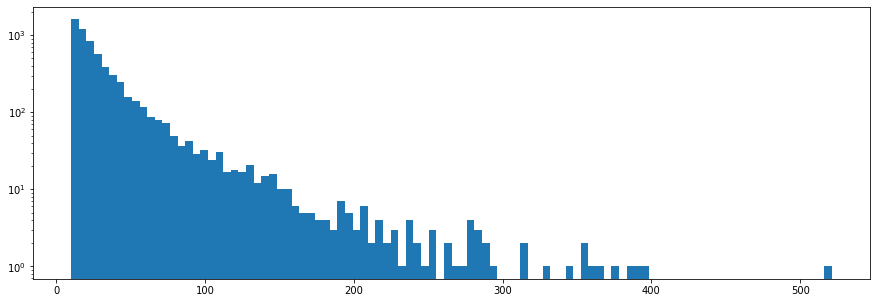

Determined optimal gaussian amplitude A = 33.57595679441267, sigma = 0.9413857827141509


In [34]:
avg_patch, optimized_patch, A_opt, sigma_opt = profile.gaussian_profile(profile_scan_file, 1000, baseline, th_single_elec=10, plot_results=True)
print(f"Determined optimal gaussian amplitude A = {A_opt}, sigma = {sigma_opt}")

##### 2. Generate frames for a single electron with different occupancies

In [35]:
def generate_single_gaussian_frames(nframes, frame_size, df, output_filename, sigma, occupancy, baseline=20, noise_sigma=1, mc_scale=1):
    """
    Generates Monte Carlo frames with electrons spread around a single Gaussian center according to a Gaussian distribution,
    adds baseline and noise, and saves them in an HDF5 file. Also saves the Monte Carlo "truth" data.
    
    Args:
    - nframes (int): Number of frames to generate.
    - frame_size (int): Size of each frame (e.g., 576 for 576x576 frames).
    - df (DataFrame): DataFrame containing electron patterns.
    - output_filename (str): Name of the output HDF5 file.
    - sigma (float): Standard deviation of the Gaussian distribution to spread the electrons around the center point.
    - occupancy (float): The average number of electrons (hits) per frame.
    - baseline (int or float): Baseline value to be added to each pixel in the frames.
    - noise_sigma (float): Standard deviation of the Gaussian noise to be added (mean = 0).
    - mc_scale (float): Scale factor to apply to MC pixel amplitudes.
    
    Returns:
    - None: Saves the generated frames and the Monte Carlo "truth" in the specified HDF5 file.
    """
    
    # Initialize an empty array to store the generated frames and the Monte Carlo truth
    frames = np.zeros((nframes, frame_size*2, frame_size*2), dtype=np.uint32)
    mc_truth = np.zeros((nframes, frame_size*2, frame_size*2), dtype=np.uint32)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    # Define central position for the Gaussian (on the larger 2x grid)
    center = np.array([int(frame_size * 0.5 * 2), int(frame_size * 0.5 * 2)])  # Center Gaussian
    
    # Define covariance matrix for Gaussian spreading (circular Gaussian)
    covariance_matrix = [[sigma**2, 0], [0, sigma**2]]
    
    # Generate frames
    for i in range(nframes):
        if(nframes < 10):
            print(f"-- Frame {i+1}/{nframes}")
        elif (i % (nframes // 10)) == 0:
            print(f"-- Frame {i+1}/{nframes}")
        
        # Generate hit positions around the center using a 2D Gaussian distribution
        num_hits = np.random.binomial(occupancy * nframes, 1./nframes)  # Total number of hits for this Gaussian
        
        if num_hits > 0:
            # Generate the positions
            hit_positions = multivariate_normal(mean=center, cov=covariance_matrix).rvs(size=num_hits)
            
            # If only one hit is generated, ensure it's treated as an array of shape (1, 2)
            if num_hits == 1:
                hit_positions = np.array([hit_positions])

            # Cast to integer pixel positions
            hit_positions = hit_positions.astype(int)
            
            for x, y in hit_positions:
                # Randomly select an event to get the electron pattern
                evt = random.choice(unique_events)
                electron_pattern = extract_electron_pattern(df, evt)

                # Determine the position of the top-left corner where the electron pattern will be positioned
                half_window = len(electron_pattern) // 2
                top_left_x = x - half_window
                top_left_y = y - half_window

                # Calculate the bounds of the pattern slice within the frame
                start_i = max(0, -top_left_x)
                start_j = max(0, -top_left_y)
                end_i = min(frame_size*2 - top_left_x, len(electron_pattern))
                end_j = min(frame_size*2 - top_left_y, len(electron_pattern))

                # Calculate the frame slice where the pattern will be added
                frame_slice_x_start = max(0, top_left_x)
                frame_slice_y_start = max(0, top_left_y)
                frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
                frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

                # Add the electron pattern slice to the current frame
                frames[i, frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
                    (electron_pattern[start_i:end_i, start_j:end_j] * mc_scale).astype(np.uint32)

                # Update the Monte Carlo "truth" frame with the true hit position
                if 0 <= x < frame_size*2 and 0 <= y < frame_size*2:
                    mc_truth[i, x, y] += np.uint32(1)
    
    # Add baseline and noise to the frames
    frames = frames + baseline
    noise = np.random.normal(0, noise_sigma, frames.shape)
    frames = frames + noise
    
    # Downsample both frames and mc_truth arrays by 2x2
    downsampled_frames = np.zeros((nframes, frame_size, frame_size), dtype=np.float32)
    downsampled_mc_truth = np.zeros((nframes, frame_size, frame_size), dtype=np.uint32)
    
    for i in range(nframes):
        downsampled_frames[i] = downsample_2x2(frames[i])
        downsampled_mc_truth[i] = downsample_2x2(mc_truth[i]) * 4
    
    # Save the frames and Monte Carlo "truth" in an HDF5 file
    with h5py.File(output_filename, 'w') as h5file:
        h5file.create_dataset('/frames', data=downsampled_frames, compression="gzip")
        h5file.create_dataset('/truth', data=downsampled_mc_truth, compression="gzip")

In [ ]:
sigma = 3
occupancies = [1, 10, 100, 1000]
nframes_occupancies = [10000, 1000, 100, 10]

In [ ]:
for occ, nframes in zip(occupancies, nframes_occupancies):
    generate_single_gaussian_frames(nframes, frame_size, df=df, output_filename=f'frames_occupancy_{occ}.h5', sigma=sigma, occupancy=occ, mc_scale=mc_scale)

In [ ]:
plot_frame_and_mc_truth('frames_occupancy_1.h5', frame_index=6) #, x_range=[40,60], y_range=[40,60])

##### 3. Count the frames

In [36]:
# Counting parameters
nframes_prior = 100
gauss_A = 40
gauss_sigma = 0.7

In [38]:
# Count the sparse frames
frames_per_batch_sparse = 1000
counting.count_frames('sparse_frames.h5', 'counted_sparse_frames.h5', frame_size, 
                      frames_per_batch_sparse, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=10000, 
                      min_loss_patience = 100, min_loss_improvement = 0.01,
                      nframes_prior=nframes_prior)#, batch_end=1)

Computing the prior...
Prior values, 100 frames, shape: (100, 51, 51)
Summed frame dimensions: (51, 51)
Counting all 1000 frames for scan of shape (1000, 1)
Analyzing in 1 batches...


 ** BATCH 0 **
-- Processing frames...
-- Counting frames...


/Users/jrenner/local/jerenner/emsim/notebooks/../gausscount/counting.py:185: RuntimeWarning: invalid value encountered in divide
  conditional_prob = np.where(p_at_least_1 > 0, p_at_least_2 / p_at_least_1, 0)
/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 100, Loss: 4223398.0
Step 200, Loss: 2520779.25
Step 300, Loss: 1765339.75
Step 400, Loss: 1322301.375
Step 500, Loss: 1030219.125
Step 600, Loss: 824375.3125
Step 700, Loss: 672989.125
Step 800, Loss: 558404.125
Step 900, Loss: 469597.375
Step 1000, Loss: 399430.34375
Step 1100, Loss: 342988.96875
Step 1200, Loss: 296792.03125
Step 1300, Loss: 259030.4375
Step 1400, Loss: 226724.25
Step 1500, Loss: 199223.84375
Step 1600, Loss: 175809.1875
Step 1700, Loss: 155677.125
Step 1800, Loss: 137835.46875
Step 1900, Loss: 122070.1015625
Step 2000, Loss: 108664.625
Step 2100, Loss: 96224.8515625
Step 2200, Loss: 85563.515625
Step 2300, Loss: 75873.2265625
Step 2400, Loss: 67118.078125
Step 2500, Loss: 59205.3828125
Step 2600, Loss: 52411.7109375
Step 2700, Loss: 46368.6171875
Step 2800, Loss: 40680.66796875
Step 2900, Loss: 35629.1015625
Step 3000, Loss: 31087.39453125
Step 3100, Loss: 27351.1171875
Step 3200, Loss: 23693.84375
Step 3300, Loss: 20529.19140625
Step 3400, Loss: 17778.3710937

([array([1.65873410e+07, 1.63799310e+07, 1.53596140e+07, ...,
         3.74185156e+03, 3.78384741e+03, 3.82663403e+03])],
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0.

In [ ]:
# Count a single frame
frames_per_batch = 10
occ = 1000
nframes = 10

raw_file = f'frames_occupancy_{occ}.h5'
counted_file = f'counted_frames_occupancy_{occ}.h5'
losses = counting.count_frames(raw_file, counted_file, nframes, frame_size, min(nframes,frames_per_batch), 
                               th_single_elec, baseline, gauss_A, gauss_sigma, 
                               loss_per_frame_stop=0.5, n_steps_max=10000,
                               min_loss_patience = 100, min_loss_improvement = 0.01,
                               nframes_prior=0)

plt.plot(losses[0][0])
plt.xlabel('Step',fontsize=14)
plt.ylabel('Loss',fontsize=14)

In [ ]:
n_steps_max = 50000

# Perform counting on the Gaussian dataset
frames_per_batch = 1000

# Count with no prior.
for occ, nframes in zip(occupancies, nframes_occupancies):
    print(f"** Counting {nframes} for occupancy {occ}...")
    raw_file = f'frames_occupancy_{occ}.h5'
    counted_file = f'counted_frames_occupancy_{occ}.h5'
    counting.count_frames(raw_file, counted_file, nframes, frame_size, min(nframes,frames_per_batch), 
                          th_single_elec, baseline, gauss_A, gauss_sigma, 
                          n_steps_max=n_steps_max, loss_per_frame_stop=0.5, 
                          min_loss_patience = 100, min_loss_improvement = 0.01,
                          nframes_prior=0)
    
# Count with prior.
for occ, nframes in zip(occupancies, nframes_occupancies):
    print(f"** Counting {nframes} for occupancy {occ} WITH PRIOR")
    raw_file = f'frames_occupancy_{occ}.h5'
    counted_file = f'counted_frames_occupancy_{occ}_prior.h5'
    counting.count_frames(raw_file, counted_file, nframes, frame_size, min(nframes,frames_per_batch), 
                          th_single_elec, baseline, gauss_A, gauss_sigma, 
                          n_steps_max=n_steps_max, loss_per_frame_stop=0.5, 
                          min_loss_patience = 100, min_loss_improvement = 0.01,
                          nframes_prior=min(nframes,nframes_prior))

In [ ]:
plot_counted_vs_mc_truth('frames_occupancy_1000.h5', 'counted_frames_occupancy_1000.h5', frame_index=5, weights=True, x_range=[int((frame_size-1)/2)-15,int((frame_size-1)/2)+15], y_range=[int((frame_size-1)/2)-15,int((frame_size-1)/2)+15])
#plot_counted_vs_mc_truth('sparse_frames.h5', 'counted_sparse_frames.h5', frame_index=3, weights=True, x_range=[30,60], y_range=[30,60])
#plot_counted_vs_mc_truth('sparse_frames.h5', 'counted_sparse_frames.h5', frame_index=0, weights=True)

##### 4. Examine the results

In [ ]:
def evaluate_counting_results_multi(raw_files, counted_files, counted_files_prior, occupancies, frame_size=101, weights=False, x_range=None, y_range=None):
    """
    Evaluate counting results by comparing the summed counted frames (with and without prior) to the MC truth.
    Generates 2D heatmaps and a 1D comparison plot along the center line for multiple occupancies.
    
    Args:
    - raw_files (list of str): Paths to the raw HDF5 files containing the MC truth for each occupancy.
    - counted_files (list of str): Paths to the HDF5 files containing the counted results for each occupancy.
    - counted_files_prior (list of str): Paths to the HDF5 files containing the counted results with prior for each occupancy.
    - frame_size (int): Size of the frames (default: 101).
    - weights (bool): Whether to use weights from the counted data (default: False).
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the heatmaps of the MC truth and the counted results, and the 1D line plot comparison for all files.
    """
    n_occupancies = len(raw_files)

    # Initialize storage for line plots
    fig, axs = plt.subplots(1, n_occupancies, figsize=(4 * n_occupancies, 4))
    fig.subplots_adjust(hspace=0.4)

    # Iterate over each occupancy
    for idx in range(n_occupancies):
        # Load data for the current occupancy
        raw_file = raw_files[idx]
        counted_file = counted_files[idx]
        counted_file_prior = counted_files_prior[idx]
        
        # Get the MC truth from the raw file and sum all hits
        with h5py.File(raw_file, 'r') as h5file:
            mc_truth = h5file['/truth'][:]
        summed_mc_truth = np.sum(mc_truth, axis=0).astype('float64')
        summed_mc_truth /= len(mc_truth)
        
        # Sum the counted frames (without prior)
        with h5py.File(counted_file, 'r') as h5file:
            nframes = len(np.array(h5file['electron_events']['frames']))
            print(f"Summing over {nframes} counted frames for file {counted_file}...")
            summed_counted_frames = np.zeros((frame_size, frame_size), dtype=np.float64)
            summed_counted_frames_noweights = np.zeros((frame_size, frame_size), dtype=np.float64)
            for iframe in range(nframes):
                frame_data = np.array(h5file['electron_events']['frames'][iframe])
                weight_data = None
                if weights:
                    weight_data = np.array(h5file['electron_events']['weights'][iframe])
                # Create 2D images of the counted frame
                counted_image = create_counted_image(frame_data, frame_size, frame_size, weight_data)
                counted_image_noweights = create_counted_image(frame_data, frame_size, frame_size, None)
                #print(f"-- Adding {np.sum(counted_image)} counts")
                summed_counted_frames += counted_image
                summed_counted_frames_noweights += counted_image_noweights
            summed_counted_frames /= nframes
            summed_counted_frames_noweights /= nframes
        
        # Sum the counted frames (with prior)
        with h5py.File(counted_file_prior, 'r') as h5file:
            nframes_prior = len(np.array(h5file['electron_events']['frames']))
            summed_counted_frames_prior = np.zeros((frame_size, frame_size), dtype=np.float64)
            for iframe in range(nframes_prior):
                frame_data_prior = np.array(h5file['electron_events']['frames'][iframe])
                weight_data_prior = None
                if weights:
                    weight_data_prior = np.array(h5file['electron_events']['weights'][iframe])
                # Create 2D images of the counted frame (with prior)
                counted_image_prior = create_counted_image(frame_data_prior, frame_size, frame_size, weight_data_prior)
                summed_counted_frames_prior += counted_image_prior
            summed_counted_frames_prior /= nframes_prior
        
        # Determine the zoom range (default is full range)
        if x_range is None:
            x_range = (0, frame_size)
        if y_range is None:
            y_range = (0, frame_size)
        
        # Extract the line through the center for each method (1D plot data)
        center = frame_size // 2
        counted_line = np.sum(summed_counted_frames[x_range[0]:x_range[1], :], axis=1)
        counted_line_noweights = np.sum(summed_counted_frames_noweights[x_range[0]:x_range[1], :], axis=1)
        counted_line_prior = np.sum(summed_counted_frames_prior[x_range[0]:x_range[1], :], axis=1)
        truth_line = np.sum(summed_mc_truth[x_range[0]:x_range[1], :], axis=1)
        x_pixels = np.arange(x_range[0], x_range[1])
        
        # Plot the results (1D line plot for each occupancy)
        axs[idx].plot(x_pixels, counted_line_noweights, label='No Weights', linestyle='--', color='green')
        axs[idx].plot(x_pixels, counted_line, label='With Weights', color='red')
        axs[idx].plot(x_pixels, counted_line_prior, label='With Prior', color='blue')
        axs[idx].plot(x_pixels, truth_line, label='MC Truth', linestyle=':', color='black')
        
        axs[idx].set_yscale("log")
        axs[idx].set_xlabel('x-pixel', fontsize=14)
        if(idx == 0): axs[idx].set_ylabel('y-projection counts/frame', fontsize=14)
        axs[idx].legend(fontsize=12)
        axs[idx].grid(True)
        #axs[idx].set_title(f'{occupancies[idx]} e$^-$/frame', fontsize=14)
    
    plt.tight_layout()
    plt.savefig("occupancy_1D.pdf",bbox_inches='tight')

# Example usage with multiple occupancy files
raw_files =           [f'frames_occupancy_{occ}.h5' for occ in occupancies]
counted_files =       [f'counted_frames_occupancy_{occ}.h5' for occ in occupancies]
counted_files_prior = [f'counted_frames_occupancy_{occ}_prior.h5' for occ in occupancies]
evaluate_counting_results_multi(
    raw_files=raw_files,
    counted_files=counted_files,
    counted_files_prior=counted_files_prior,
    occupancies=occupancies,
    frame_size=frame_size,
    weights=True,
    x_range=[int((frame_size-1)/2)-5,int((frame_size-1)/2)+6],
    y_range=[int((frame_size-1)/2)-5,int((frame_size-1)/2)+6]
)

In [ ]:
def evaluate_counting_results_2D(raw_files, counted_files, counted_files_prior, occupancies, nframes_occupancies, frame_size=101, weights=False, x_range=None, y_range=None, plot_MC_truth_only = False):
    """
    Evaluate counting results by comparing the summed counted frames (with and without prior) to the MC truth.
    Generates 2D heatmaps and a 1D comparison plot along the center line for multiple occupancies.
    
    Args:
    - raw_files (list of str): Paths to the raw HDF5 files containing the MC truth for each occupancy.
    - counted_files (list of str): Paths to the HDF5 files containing the counted results for each occupancy.
    - counted_files_prior (list of str): Paths to the HDF5 files containing the counted results with prior for each occupancy.
    - occupancies (list of int): the number of electron hits per frame corresponding to each file
    - nframes_occupancies (list of int): the nominal total number of frames corresponding to each file (note, the user must ensure this is correct)
    - frame_size (int): Size of the frames (default: 101).
    - weights (bool): Whether to use weights from the counted data (default: False).
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the heatmaps of the MC truth and the counted results, and the 1D line plot comparison for all files.
    """
    n_occupancies = len(raw_files)
    
    # Initialize storage for line plots
    line_truth_all = []
    line_counted_all = []
    line_counted_prior_all = []
    line_counted_noweights_all = []
    x_pixels_all = []
    
    if(plot_MC_truth_only):
        fig, axs = plt.subplots(1, n_occupancies, figsize=(4 * n_occupancies, 3.0))
    else:
        fig, axs = plt.subplots(4, n_occupancies, figsize=(4 * n_occupancies, 16))
    fig.subplots_adjust(hspace=0.4)
    
    # Iterate over each occupancy
    for idx in range(n_occupancies):
        # Load data for the current occupancy
        raw_file = raw_files[idx]
        counted_file = counted_files[idx]
        counted_file_prior = counted_files_prior[idx]
        
        # Get the MC truth from the raw file and sum all hits
        with h5py.File(raw_file, 'r') as h5file:
            mc_truth = h5file['/truth'][:]
        summed_mc_truth = np.sum(mc_truth, axis=0)
        
        # Sum the counted frames (without prior)
        with h5py.File(counted_file, 'r') as h5file:
            nframes = len(np.array(h5file['electron_events']['frames']))
            print(f"Summing {nframes} frames...")
            summed_counted_frames = np.zeros((frame_size, frame_size), dtype=np.int32)
            summed_counted_frames_noweights = np.zeros((frame_size, frame_size), dtype=np.int32)
            for iframe in range(nframes):
                frame_data = np.array(h5file['electron_events']['frames'][iframe])
                weight_data = None
                if weights:
                    weight_data = np.array(h5file['electron_events']['weights'][iframe])
                # Create 2D images of the counted frame
                counted_image = create_counted_image(frame_data, frame_size, frame_size, weight_data)
                counted_image_noweights = create_counted_image(frame_data, frame_size, frame_size, None)
                summed_counted_frames += counted_image
                summed_counted_frames_noweights += counted_image_noweights
        
        # Sum the counted frames (with prior)
        with h5py.File(counted_file_prior, 'r') as h5file:
            nframes_prior = len(np.array(h5file['electron_events']['frames']))
            summed_counted_frames_prior = np.zeros((frame_size, frame_size), dtype=np.int32)
            for iframe in range(nframes_prior):
                frame_data_prior = np.array(h5file['electron_events']['frames'][iframe])
                weight_data_prior = None
                if weights:
                    weight_data_prior = np.array(h5file['electron_events']['weights'][iframe])
                # Create 2D images of the counted frame (with prior)
                counted_image_prior = create_counted_image(frame_data_prior, frame_size, frame_size, weight_data_prior)
                summed_counted_frames_prior += counted_image_prior
        
        # Determine the zoom range (default is full range)
        if x_range is None:
            x_range = (0, frame_size)
        if y_range is None:
            y_range = (0, frame_size)
        
        # Apply zoom
        summed_mc_truth_zoomed = summed_mc_truth[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        summed_counted_frames_zoomed = summed_counted_frames[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        summed_counted_frames_noweights_zoomed = summed_counted_frames_noweights[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        summed_counted_frames_prior_zoomed = summed_counted_frames_prior[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        
        # Plot heatmaps for the current occupancy
        if(plot_MC_truth_only):
            im0 = axs[idx].imshow(summed_mc_truth_zoomed/nframes_occupancies[idx], cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]), rasterized=True, norm=LogNorm())
            axs[idx].set_title(f'{occupancies[idx]} e$^-$/frame')
            fig.colorbar(im0, ax=axs[idx], orientation='vertical')
            axs[idx].set_xlabel('x-pixel',fontsize=14)
            if(idx == 0): axs[idx].set_ylabel('y-pixel',fontsize=14)
        else:            
            im0 = axs[0, idx].imshow(np.log(summed_mc_truth_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
            axs[0, idx].set_title(f'MC Truth ({occupancies[idx]} e$^-$/frame)')
            fig.colorbar(im0, ax=axs[0, idx], orientation='vertical')

            im1 = axs[1, idx].imshow(np.log(summed_counted_frames_noweights_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
            axs[1, idx].set_title(f'No Weights ({occupancies[idx]} e$^-$/frame)')
            fig.colorbar(im1, ax=axs[1, idx], orientation='vertical')

            im2 = axs[2, idx].imshow(np.log(summed_counted_frames_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
            axs[2, idx].set_title(f'With Weights ({occupancies[idx]} e$^-$/frame)')
            fig.colorbar(im2, ax=axs[2, idx], orientation='vertical')

            im3 = axs[3, idx].imshow(np.log(summed_counted_frames_prior_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
            axs[3, idx].set_title(f'With Prior ({occupancies[idx]} e$^-$/frame)')
            fig.colorbar(im3, ax=axs[3, idx], orientation='vertical')
        
        # Extract the line through the center for each method (1D plot data)
        center = frame_size // 2
        counted_line = np.sum(summed_counted_frames[x_range[0]:x_range[1], :], axis=1)
        counted_line_noweights = np.sum(summed_counted_frames_noweights[x_range[0]:x_range[1], :], axis=1)
        counted_line_prior = np.sum(summed_counted_frames_prior[x_range[0]:x_range[1], :], axis=1)
        truth_line = np.sum(summed_mc_truth[x_range[0]:x_range[1], :], axis=1)
        x_pixels = np.arange(x_range[0], x_range[1])
        
        # Store for line plot
        line_truth_all.append(truth_line)
        line_counted_all.append(counted_line)
        line_counted_prior_all.append(counted_line_prior)
        line_counted_noweights_all.append(counted_line_noweights)
        x_pixels_all.append(x_pixels)
    
    if(plot_MC_truth_only): plt.savefig("occupancy_2D_MC.pdf",bbox_inches='tight',dpi=600,transparent=False)
    else: plt.savefig("occupancy_2D.pdf",dpi=300,transparent=False)
    
    # Plot the results (1D comparison)
    plt.figure(figsize=(12, 5))
    for idx in range(n_occupancies):
        plt.plot(x_pixels_all[idx], line_counted_noweights_all[idx], label=f'Occ {idx+1} No Wts', linestyle='--')
        plt.plot(x_pixels_all[idx], line_counted_all[idx], label=f'Occ {idx+1} Wts')
        plt.plot(x_pixels_all[idx], line_counted_prior_all[idx], label=f'Occ {idx+1} Prior')
        plt.plot(x_pixels_all[idx], line_truth_all[idx], label=f'Occ {idx+1} MC Truth', linestyle=':')
    
    plt.yscale("log")
    plt.xlabel('x-pixel', fontsize=14)
    plt.ylabel('y-projection counts', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with multiple occupancy files
raw_files =           [f'frames_occupancy_{occ}.h5' for occ in occupancies]
counted_files =       [f'counted_frames_occupancy_{occ}.h5' for occ in occupancies]
counted_files_prior = [f'counted_frames_occupancy_{occ}_prior.h5' for occ in occupancies]
evaluate_counting_results_2D(
    raw_files=raw_files,
    counted_files=counted_files,
    counted_files_prior=counted_files_prior,
    occupancies=occupancies,
    nframes_occupancies=nframes_occupancies,
    frame_size=frame_size,
    weights=True,
    x_range=[int((frame_size-1)/2)-15,int((frame_size-1)/2)+16],
    y_range=[int((frame_size-1)/2)-15,int((frame_size-1)/2)+16],
    plot_MC_truth_only = False
)

## Plots for explanation of method

In [ ]:
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

In [ ]:
# Generate hit positions for an example frame.
raw_filename = "example_frame.h5"
baseline = 20
noise_sigma = 1
th_single_elec = 10
mc_scale = 0.2

frame_size = 21
nframes = 10
average_occupancy = 0.02

np.random.seed(42)
total_pixels = frame_size * frame_size
total_hits = int(nframes * total_pixels * average_occupancy)

# Randomly generate hit positions and their frame indices
hit_positions = np.random.randint(0, frame_size*2, size=(total_hits, 2))
frame_indices = np.random.randint(0, nframes, size=total_hits)

# Convert to a list of frame-specific hit positions
hit_positions_per_frame = [[] for _ in range(nframes)]
for pos, frame_idx in zip(hit_positions, frame_indices):
    hit_positions_per_frame[frame_idx].append(tuple(pos))

# Multiplicities (all 1 for sparse hits)
multiplicities_per_frame = []
for hits in hit_positions_per_frame:
    multiplicities = []
    for i in range(len(hits)):
        multiplicities.append(1)
    multiplicities_per_frame.append(multiplicities)

# Save the generated sparse frames
generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, 
                         nframes, frame_size, output_filename=raw_filename, 
                         baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

In [ ]:
frame_index = 0

Plot the raw frame

In [ ]:
# Open the HDF5 file
with h5py.File(raw_filename, 'r') as h5file:
    
    # Load the specific frame
    frame = h5file['/frames'][frame_index]

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot the frame
im0 = axs.imshow(frame, cmap='gray')
#axs.set_title(f'Frame {frame_index} (Zoomed)')
axs.axis('off')
#fig.colorbar(im0, ax=axs, orientation='vertical')
plt.savefig("example_frame_raw.pdf")

Do a basic counting

In [ ]:
# Counting parameters
counted_file = f'counted_example_frames.h5'
nframes_prior = 0
gauss_A = 40
gauss_sigma = 0.7
frames_per_batch = 100

In [ ]:
# Count
losses, frame_ct_reco, modeled_frame_reco = counting.count_frames(raw_filename, counted_file, nframes, frame_size, min(nframes,frames_per_batch), 
                               th_single_elec, baseline, gauss_A, gauss_sigma, 
                               n_steps_max = 100, loss_per_frame_stop=0.5, min_loss_improvement = 0.01,
                               nframes_prior=0)

plt.plot(losses[0])
plt.xlabel('Step',fontsize=14)
plt.ylabel('Loss',fontsize=14)

In [ ]:
# Plot the counted frame
plt.imshow(frame_ct_reco[frame_index],cmap="gray")
plt.axis('off')
plt.savefig("example_frame_counted.pdf")

In [ ]:
# Plot the reconstructed frame
plt.imshow(modeled_frame_reco[frame_index],cmap="gray")
plt.axis('off')
plt.savefig("example_frame_reco.pdf")

In [ ]:
# Load the counted data for the selected frame
weights = True
with h5py.File(counted_file, 'r') as h5file:
    frame_data = np.array(h5file['electron_events']['frames'][frame_index])
    weight_data = None
    if weights:
        weight_data = np.array(h5file['electron_events']['weights'][frame_index])

    # Convert the counted data into a 2D image
    counted_image = create_counted_image(frame_data, frame_size, frame_size, weight_data)

# Plot the counted data
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot the counted data
im1 = axs.imshow(counted_image, cmap='gray')
#axs.set_title(f'Counted Frame {frame_index} ({np.sum(counted_image)} counts)')
axs.axis('off')
fig.colorbar(im1, ax=axs, orientation='vertical')
#plt.savefig()

In [ ]:
plot_counted_vs_mc_truth(raw_filename, counted_file, frame_index=0, weights=True)

In [ ]:
plot_frame_and_mc_truth('example_frame.h5', frame_index=0)

Gaussian kernel

In [ ]:
# Define the Gaussian function for fitting
def gaussian(x, y, A, sigma):
    return A * np.exp(-((x-1)**2 + (y-1)**2) / (2*sigma**2))

# Generate the optimized 3x3 Gaussian patch
optimized_patch = np.array([[gaussian(x, y, gauss_A, gauss_sigma) for y in range(3)] for x in range(3)])

fig, axs = plt.subplots(1, 1, figsize=(5, 4))

# Optimized Gaussian patch
ax1 = axs.imshow(optimized_patch, cmap='gray')
#fig.colorbar(ax1, ax=axs)
#axs.set_title('Optimized Gaussian Patch')
axs.axis('off')

plt.savefig("gauss_kernel.pdf")

In [ ]:
# Lists to be sorted
list1 = [5, 2, 9, 1, 7]  # The values you want to sort
list2 = ['a', 'b', 'c', 'd', 'e']  # The list to sort by

# Sort list1 according to the order in list2
sorted_list2 = [x for _, x in sorted(zip(list1, list2))]

In [ ]:
sorted_list2

## Old code

#### Single-point occupancy experiment

In [ ]:
# Define the center position.
center_position = [(frame_size, frame_size)]

# Generate and save the concentrated hit frames for each occupancy level
for occupancy in occupancies:
    
    # Cast the multiplicities.
    # Binomial distribution with:
    # - number of trials = (occupancy) * (nframes) = avg. number of electrons per frame
    # - probability = 1/nframes, so that the average number of electrons per frame is = (occupancy*nframes)/nframes = occupancy
    # - vector size: number of frames
    multiplicities = np.random.binomial(occupancy*nframes_occupancy, 1./nframes_occupancy, nframes_occupancy)
    
    # Prepare the hit position and multiplicity arrays for each frame (each one a list of 1 element).
    hit_positions_per_frame, multiplicities_per_frame = [], []
    for iframe in range(nframes_occupancy):
        hit_positions_per_frame.append(center_position)
        multiplicities_per_frame.append([multiplicities[iframe]])
    
    print(f"Generating frames for occupancy {occupancy}...")
    generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes_occupancy, frame_size, output_filename=f'frames_occupancy_{occupancy}.h5', baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

In [ ]:
# Define the center position.
center_position = [(frame_size, frame_size)]

# Generate and save the concentrated hit frames for each occupancy level
for occupancy in occupancies:
    
    # Cast the multiplicities.
    # Binomial distribution with:
    # - number of trials = (occupancy) * (nframes) = avg. number of electrons per frame
    # - probability = 1/nframes, so that the average number of electrons per frame is = (occupancy*nframes)/nframes = occupancy
    # - vector size: number of frames
    multiplicities = np.random.binomial(occupancy*nframes_occupancy, 1./nframes_occupancy, nframes_occupancy)
    
    # Prepare the hit position and multiplicity arrays for each frame (each one a list of 1 element).
    hit_positions_per_frame, multiplicities_per_frame = [], []
    for iframe in range(nframes_occupancy):
        hit_positions_per_frame.append(center_position)
        multiplicities_per_frame.append([multiplicities[iframe]])
    
    print(f"Generating frames for occupancy {occupancy}...")
    generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes_occupancy, frame_size, output_filename=f'frames_occupancy_{occupancy}.h5', baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

In [ ]:
# Counting parameters
n_steps_max = 2000
frame_size = 101  
nframes_prior = 1000
gauss_A = 12
gauss_sigma = 0.7

frames_per_batch = 1000
frames_per_batch_sparse = 1000

# Perform counting on the sparse dataset
counting.count_frames('sparse_frames.h5', 'counted_sparse_frames.h5', nframes_sparse, frame_size, frames_per_batch_sparse, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=nframes_prior)#, batch_end=1)

# Perform counting on the concentrated datasets
for occupancy in occupancies:
    
    raw_file = f'frames_occupancy_{occupancy}.h5'
    
    # Count with no prior.
    counted_file = f'counted_frames_occupancy_{occupancy}.h5'
    counting.count_frames(raw_file, counted_file, nframes_occupancy, frame_size, frames_per_batch, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=0)
    
    # Count with prior.
    counted_file_prior = f'counted_frames_occupancy_{occupancy}_prior.h5'
    counting.count_frames(raw_file, counted_file_prior, nframes_occupancy, frame_size, frames_per_batch, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=nframes_prior)

In [ ]:
def evaluate_counting_results(raw_file, counted_file, counted_file_prior, frame_size=101, weights=False, x_range=None, y_range=None):
    """
    Evaluate counting results by comparing the summed counted frames (with and without prior) to the MC truth.
    Generates 2D heatmaps and a 1D comparison plot along the center line.
    
    Args:
    - raw_file (str): Path to the raw HDF5 file containing the MC truth.
    - counted_file (str): Path to the HDF5 file containing the counted results.
    - counted_file_prior (str): Path to the HDF5 file containing the counted results with prior.
    - frame_size (int): Size of the frames (default: 101).
    - weights (bool): Whether to use weights from the counted data (default: False).
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the heatmaps of the MC truth and the counted results, and the 1D line plot comparison.
    """
    # Get the MC truth from the raw file and sum all hits.
    with h5py.File(raw_file, 'r') as h5file:
        mc_truth = h5file['/truth'][:]
    summed_mc_truth = np.sum(mc_truth, axis=0)
    
    # Sum the counted frames (without prior)
    with h5py.File(counted_file, 'r') as h5file:
        nframes = len(np.array(h5file['electron_events']['frames']))
        summed_counted_frames = np.zeros((frame_size, frame_size), dtype=np.int32)
        nelec = 0
        for iframe in range(nframes):
            frame_data = np.array(h5file['electron_events']['frames'][iframe])
            weight_data = None
            if weights:
                weight_data = np.array(h5file['electron_events']['weights'][iframe])

            # Create a 2D image of the counted frame
            counted_image = create_counted_image(frame_data, frame_size, frame_size, weight_data)

            # Sum the counted images
            summed_counted_frames += counted_image
            nelec += len(frame_data)
    
    # Sum the counted frames (with prior)
    with h5py.File(counted_file_prior, 'r') as h5file:
        nframes_prior = len(np.array(h5file['electron_events']['frames']))
        summed_counted_frames_prior = np.zeros((frame_size, frame_size), dtype=np.int32)
        nelec_prior = 0
        for iframe in range(nframes_prior):
            frame_data_prior = np.array(h5file['electron_events']['frames'][iframe])
            weight_data_prior = None
            if weights:
                weight_data_prior = np.array(h5file['electron_events']['weights'][iframe])

            # Create a 2D image of the counted frame (with prior)
            counted_image_prior = create_counted_image(frame_data_prior, frame_size, frame_size, weight_data_prior)

            # Sum the counted images
            summed_counted_frames_prior += counted_image_prior
            nelec_prior += len(frame_data_prior)

    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame_size)
    if y_range is None:
        y_range = (0, frame_size)
    
    # Apply zoom
    summed_mc_truth_zoomed = summed_mc_truth[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    summed_counted_frames_zoomed = summed_counted_frames[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    summed_counted_frames_prior_zoomed = summed_counted_frames_prior[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot 2D heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    # MC truth heatmap
    im0 = axs[0].imshow(summed_mc_truth_zoomed, cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Summed MC Truth (total {np.sum(summed_mc_truth)})')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Counted result heatmap (without prior)
    im1 = axs[1].imshow(summed_counted_frames_zoomed, cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title(f'Summed counted frames (total {np.sum(summed_counted_frames)})')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    # Counted result heatmap (with prior)
    im2 = axs[2].imshow(summed_counted_frames_prior_zoomed, cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[2].set_title(f'Summed counted frames with prior (total {np.sum(summed_counted_frames_prior)})')
    fig.colorbar(im2, ax=axs[2], orientation='vertical')
    
    plt.show()
    
    # Plot the results (1D)
    # Extract the line through the center (50,50)
    center = frame_size // 2
    counted_line = summed_counted_frames[center, x_range[0]:x_range[1]]
    counted_line_prior = summed_counted_frames_prior[center, x_range[0]:x_range[1]]
    truth_line = summed_mc_truth[center, x_range[0]:x_range[1]]
    x_pixels = np.arange(x_range[0],x_range[1])
    
    plt.figure(figsize=(7, 3))
    plt.plot(x_pixels,counted_line, label='Counted (No Prior)', color='blue')
    plt.plot(x_pixels,counted_line_prior, label='Counted (With Prior)', color='green')
    plt.plot(x_pixels,truth_line, label='MC Truth', linestyle='--', color='red')
    #plt.title('Counted vs. MC Truth (Line Through Center)')
    plt.xlabel('Pixel',fontsize=14)
    plt.ylabel('Counts',fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate the sparse counting results
#evaluate_counting_results('sparse_frames.h5', 'counted_sparse_frames.h5')
evaluate_counting_results('frames_occupancy_1.h5', 'counted_frames_occupancy_1.h5', 
                          'counted_frames_occupancy_1_prior.h5', weights=True, x_range=[45,56], y_range=[45,56])

#### Tri-point occupancy study

In [ ]:
def generate_gaussian_spread_frames(nframes, frame_size, df, output_filename, sigma, occupancies, baseline=20, noise_sigma=1, mc_scale=1):
    """
    Generates Monte Carlo frames with electrons spread around 3 Gaussian centers according to a Gaussian distribution,
    adds baseline and noise, and saves them in an HDF5 file. Also saves the Monte Carlo "truth" data.
    
    Args:
    - nframes (int): Number of frames to generate.
    - frame_size (int): Size of each frame (e.g., 576 for 576x576 frames).
    - df (DataFrame): DataFrame containing electron patterns.
    - output_filename (str): Name of the output HDF5 file.
    - sigma (float): Standard deviation of the Gaussian distribution to spread the electrons around the central points.
    - occupancies (list of floats): List of occupancies for each Gaussian center (e.g., [0.1, 1, 10]).
    - baseline (int or float): Baseline value to be added to each pixel in the frames.
    - noise_sigma (float): Standard deviation of the Gaussian noise to be added (mean = 0).
    - mc_scale (float): Scale factor to apply to MC pixel amplitudes.
    
    Returns:
    - None: Saves the generated frames and the Monte Carlo "truth" in the specified HDF5 file.
    """
    
    # Initialize an empty array to store the generated frames and the Monte Carlo truth
    frames = np.zeros((nframes, frame_size*2, frame_size*2), dtype=np.uint32)
    mc_truth = np.zeros((nframes, frame_size*2, frame_size*2), dtype=np.uint32)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    # Define central positions for the 3 Gaussians (on the larger 2x grid)
    left_center = np.array([int(frame_size * 0.25 * 2), int(frame_size * 0.5 * 2)])  # Left Gaussian
    center_center = np.array([int(frame_size * 0.5 * 2), int(frame_size * 0.5 * 2)])  # Center Gaussian
    right_center = np.array([int(frame_size * 0.75 * 2), int(frame_size * 0.5 * 2)])  # Right Gaussian
    
    # Define covariance matrix for Gaussian spreading (circular Gaussian)
    covariance_matrix = [[sigma**2, 0], [0, sigma**2]]
    
    # Generate frames
    for i in range(nframes):
        if((i % (nframes/100)) == 0):
            print(f"-- Frame {i}")
        for center, occupancy in zip([left_center, center_center, right_center], occupancies):
            
            # Generate hit positions around the center using a 2D Gaussian distribution
            num_hits = np.random.binomial(occupancy * nframes, 1./nframes)  # Total number of hits for this Gaussian
            if num_hits > 0:
                # Generate the positions
                hit_positions = multivariate_normal(mean=center, cov=covariance_matrix).rvs(size=num_hits)
                
                # If only one hit is generated, ensure it's treated as an array of shape (1, 2)
                if num_hits == 1:
                    hit_positions = np.array([hit_positions])

                # Cast to integer pixel positions
                hit_positions = hit_positions.astype(int)
                
                for x, y in hit_positions:
                    # Randomly select an event to get the electron pattern
                    evt = random.choice(unique_events)
                    electron_pattern = extract_electron_pattern(df, evt)

                    # Determine the position of the top-left corner where the electron pattern will be positioned
                    half_window = len(electron_pattern) // 2
                    top_left_x = x - half_window
                    top_left_y = y - half_window

                    # Calculate the bounds of the pattern slice within the frame
                    start_i = max(0, -top_left_x)
                    start_j = max(0, -top_left_y)
                    end_i = min(frame_size*2 - top_left_x, len(electron_pattern))
                    end_j = min(frame_size*2 - top_left_y, len(electron_pattern))

                    # Calculate the frame slice where the pattern will be added
                    frame_slice_x_start = max(0, top_left_x)
                    frame_slice_y_start = max(0, top_left_y)
                    frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
                    frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

                    # Add the electron pattern slice to the current frame
                    frames[i, frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
                        (electron_pattern[start_i:end_i, start_j:end_j] * mc_scale).astype(np.uint32)

                    # Update the Monte Carlo "truth" frame with the true hit position
                    if 0 <= x < frame_size*2 and 0 <= y < frame_size*2:
                        mc_truth[i, x, y] += np.uint32(1)
    
    # Add baseline and noise to the frames
    frames = frames + baseline
    noise = np.random.normal(0, noise_sigma, frames.shape)
    frames = frames + noise
    
    # Downsample both frames and mc_truth arrays by 2x2
    downsampled_frames = np.zeros((nframes, frame_size, frame_size), dtype=np.float32)
    downsampled_mc_truth = np.zeros((nframes, frame_size, frame_size), dtype=np.uint32)
    
    for i in range(nframes):
        downsampled_frames[i] = downsample_2x2(frames[i])
        downsampled_mc_truth[i] = downsample_2x2(mc_truth[i]) * 4
    
    # Save the frames and Monte Carlo "truth" in an HDF5 file
    with h5py.File(output_filename, 'w') as h5file:
        h5file.create_dataset('/frames', data=downsampled_frames, compression="gzip")
        h5file.create_dataset('/truth', data=downsampled_mc_truth, compression="gzip")

In [ ]:
sigma = 3  # Standard deviation for the spread of each Gaussian

# Generate the frames with Gaussian-spread hit positions
generate_gaussian_spread_frames(nframes=nframes_occupancy, frame_size=frame_size, df=df, output_filename='gaussian_spread_frames.h5', sigma=sigma, occupancies=occupancies, baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

In [ ]:
plot_frame_and_mc_truth('gaussian_spread_frames.h5', frame_index=3) #, x_range=[40,60], y_range=[40,60])

Count frames

In [ ]:
# Counting parameters
n_steps_max = 2000
frame_size = 101  
nframes_prior = 100
gauss_A = 12
gauss_sigma = 0.7

frames_per_batch = 100
frames_per_batch_sparse = 1000

# Perform counting on the sparse dataset
#counting.count_frames('sparse_frames.h5', 'counted_sparse_frames.h5', nframes_sparse, frame_size, frames_per_batch_sparse, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=nframes_prior)#, batch_end=1)

# Perform counting on the Gaussian dataset
raw_file = f'gaussian_spread_frames.h5'
    
# Count with no prior.
counted_file = f'counted_frames_gaussian_spread.h5'
counting.count_frames(raw_file, counted_file, nframes_occupancy, frame_size, frames_per_batch, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=0)
    
# Count with prior.
counted_file_prior = f'counted_frames_gaussian_spread_prior.h5'
counting.count_frames(raw_file, counted_file_prior, nframes_occupancy, frame_size, frames_per_batch, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=nframes_prior)

In [ ]:
plot_counted_vs_mc_truth('gaussian_spread_frames.h5', 'counted_frames_gaussian_spread_prior.h5', frame_index=10, weights=True)#, x_range=[30,60], y_range=[30,60])

Examine results

In [ ]:
def evaluate_counting_results(raw_file, counted_file, counted_file_prior, frame_size=101, weights=False, x_range=None, y_range=None):
    """
    Evaluate counting results by comparing the summed counted frames (with and without prior) to the MC truth.
    Generates 2D heatmaps and a 1D comparison plot along the center line.
    
    Args:
    - raw_file (str): Path to the raw HDF5 file containing the MC truth.
    - counted_file (str): Path to the HDF5 file containing the counted results.
    - counted_file_prior (str): Path to the HDF5 file containing the counted results with prior.
    - frame_size (int): Size of the frames (default: 101).
    - weights (bool): Whether to use weights from the counted data (default: False).
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the heatmaps of the MC truth and the counted results, and the 1D line plot comparison.
    """
    # Get the MC truth from the raw file and sum all hits.
    with h5py.File(raw_file, 'r') as h5file:
        mc_truth = h5file['/truth'][:]
    summed_mc_truth = np.sum(mc_truth, axis=0)
    
    # Sum the counted frames (without prior)
    with h5py.File(counted_file, 'r') as h5file:
        nframes = len(np.array(h5file['electron_events']['frames']))
        summed_counted_frames = np.zeros((frame_size, frame_size), dtype=np.int32)
        summed_counted_frames_noweights = np.zeros((frame_size, frame_size), dtype=np.int32)
        nelec = 0
        for iframe in range(nframes):
            frame_data = np.array(h5file['electron_events']['frames'][iframe])
            weight_data = None
            if weights:
                weight_data = np.array(h5file['electron_events']['weights'][iframe])

            # Create a 2D image of the counted frame
            counted_image = create_counted_image(frame_data, frame_size, frame_size, weight_data)
            counted_image_noweights = create_counted_image(frame_data, frame_size, frame_size, None)

            # Sum the counted images
            summed_counted_frames += counted_image
            summed_counted_frames_noweights += counted_image_noweights
            nelec += len(frame_data)
    
    # Sum the counted frames (with prior)
    with h5py.File(counted_file_prior, 'r') as h5file:
        nframes_prior = len(np.array(h5file['electron_events']['frames']))
        summed_counted_frames_prior = np.zeros((frame_size, frame_size), dtype=np.int32)
        nelec_prior = 0
        for iframe in range(nframes_prior):
            frame_data_prior = np.array(h5file['electron_events']['frames'][iframe])
            weight_data_prior = None
            if weights:
                weight_data_prior = np.array(h5file['electron_events']['weights'][iframe])

            # Create a 2D image of the counted frame (with prior)
            counted_image_prior = create_counted_image(frame_data_prior, frame_size, frame_size, weight_data_prior)

            # Sum the counted images
            summed_counted_frames_prior += counted_image_prior
            nelec_prior += len(frame_data_prior)

    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame_size)
    if y_range is None:
        y_range = (0, frame_size)
    
    # Apply zoom
    summed_mc_truth_zoomed = summed_mc_truth[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    summed_counted_frames_zoomed = summed_counted_frames[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    summed_counted_frames_noweights_zoomed = summed_counted_frames_noweights[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    summed_counted_frames_prior_zoomed = summed_counted_frames_prior[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot 2D heatmaps
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    
    # MC truth heatmap
    im0 = axs[0].imshow(np.log(summed_mc_truth_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'MC Truth (total {np.sum(summed_mc_truth)})')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Counted result heatmap (without prior)
    im1 = axs[1].imshow(np.log(summed_counted_frames_noweights_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title(f'Counted, no wts (total {np.sum(summed_counted_frames_noweights)})')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    # Counted result heatmap (without prior)
    im2 = axs[2].imshow(np.log(summed_counted_frames_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[2].set_title(f'Counted, with wts (total {np.sum(summed_counted_frames)})')
    fig.colorbar(im2, ax=axs[2], orientation='vertical')
    
    # Counted result heatmap (with prior)
    im3 = axs[3].imshow(np.log(summed_counted_frames_prior_zoomed), cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[3].set_title(f'Counted, wts+prior (total {np.sum(summed_counted_frames_prior)})')
    fig.colorbar(im3, ax=axs[3], orientation='vertical')
    
    plt.show()
    
    # Plot the results (1D)
    # Extract the line through the center (50,50)
    center = frame_size // 2
    counted_line = np.sum(summed_counted_frames[x_range[0]:x_range[1], :],axis=1)
    counted_line_noweights = np.sum(summed_counted_frames_noweights[x_range[0]:x_range[1], :],axis=1)
    counted_line_prior = np.sum(summed_counted_frames_prior[x_range[0]:x_range[1], :],axis=1)
    truth_line = np.sum(summed_mc_truth[x_range[0]:x_range[1], :],axis=1)
    x_pixels = np.arange(x_range[0],x_range[1])
    
    plt.figure(figsize=(12, 5))
    plt.plot(x_pixels,counted_line_noweights, label='Counted, no wts', color='green')
    plt.plot(x_pixels,counted_line, label='Counted, wts', color='red')
    plt.plot(x_pixels,counted_line_prior, label='Counted, wts+prior', color='blue')
    plt.plot(x_pixels,truth_line, label='MC Truth', linestyle='--', color='black')
    plt.yscale("log")
    #plt.title('Counted vs. MC Truth (Line Through Center)')
    plt.xlabel('x-pixel',fontsize=14)
    plt.ylabel('y-projection counts',fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate the sparse counting results
#evaluate_counting_results('sparse_frames.h5', 'counted_sparse_frames.h5')
evaluate_counting_results('gaussian_spread_frames.h5', 'counted_frames_gaussian_spread.h5', 
                          'counted_frames_gaussian_spread_prior.h5', weights=True) #, x_range=[45,56], y_range=[45,56])

#### Crystal lattice generation

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
def simulate_diffraction_pattern(probe_x, probe_y, reciprocal_lattice_vectors, detector_size, sigma=1.0):
    """
    Simulate a diffraction pattern with probe position affecting the phase shift.
    
    Args:
    - probe_x, probe_y (float): Real-space probe position (x, y) that introduces a phase shift.
    - reciprocal_lattice_vectors (list of tuples): Reciprocal lattice vectors (h, k) for Bragg spots.
    - detector_size (int): Size of the detector (NxN grid).
    - sigma (float): Standard deviation for Gaussian spots representing Bragg peaks.
    
    Returns:
    - diffraction_pattern (2D numpy array): Simulated diffraction pattern.
    """
    diffraction_pattern = np.zeros((detector_size, detector_size))
    
    # Center of the diffraction pattern
    center = detector_size // 2
    
    # Real-space probe introduces a phase shift depending on its position
    phase_shift = np.exp(2j * np.pi * (probe_x + probe_y))  # Simple phase shift for probe position
    
    for (h, k) in reciprocal_lattice_vectors:
        # Map the reciprocal lattice point to the detector grid
        x = center + int(h)
        y = center + int(k)
        
        if 0 <= x < detector_size and 0 <= y < detector_size:
            # Add a Gaussian blob at the Bragg spot position
            intensity = np.abs(phase_shift)  # Intensity modulated by the phase shift
            diffraction_pattern[y, x] = intensity
    
    # Apply Gaussian smoothing to simulate spot size
    diffraction_pattern = gaussian_filter(diffraction_pattern, sigma=sigma)
    
    return diffraction_pattern

# Define the reciprocal lattice vectors (e.g., for a simple square lattice)
reciprocal_lattice_vectors = [(0, 0), (1, 0), (0, 1), (-1, 0), (0, -1),
                              (1, 1), (-1, 1), (1, -1), (-1, -1)]

# Scale the reciprocal lattice vectors to spread them out
scale_factor = 40  # Adjust this factor to increase/decrease spread
reciprocal_lattice_vectors = [(h * scale_factor, k * scale_factor) for h, k in reciprocal_lattice_vectors]

# Simulate diffraction patterns for multiple probe positions
detector_size = 128  # Define detector size (128x128 pixels)
sigma = 3.0  # Gaussian spot width

# Define the grid of probe positions (real-space)
n_probes = 50  # Define a grid of 50x50 probe positions
probe_positions = np.linspace(-5, 5, n_probes)  # Probe positions in real-space (arbitrary units)

diffraction_patterns = []

for probe_x in probe_positions:
    for probe_y in probe_positions:
        # Simulate diffraction pattern for each probe position
        diffraction_pattern = simulate_diffraction_pattern(probe_x, probe_y, reciprocal_lattice_vectors, detector_size, sigma)
        diffraction_patterns.append(diffraction_pattern)

# Sum the diffraction patterns across all probe positions
summed_diffraction_pattern = np.sum(diffraction_patterns, axis=0)

# Plot the summed diffraction pattern
plt.imshow(summed_diffraction_pattern, cmap='hot', extent=[-detector_size//2, detector_size//2, -detector_size//2, detector_size//2])
plt.colorbar()
plt.title("Simulated Summed Diffraction Pattern (with Probe Effect)")
plt.xlabel("Reciprocal Space (h)")
plt.ylabel("Reciprocal Space (k)")
plt.show()

##### Test: save some frames and examine them

In [ ]:
# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

# Specify hit positions and multiplicities
nframes = 10
hit_positions = [(50, 50), (60, 40)]
hit_positions_per_frame = [hit_positions for _ in range(nframes)]
multiplicities = [10, 20] * nframes  # Corresponding multiplicities for each hit position
multiplicities_per_frame = [multiplicities for _ in range(nframes)]

# Generate and save the frames with baseline and noise, and save the Monte Carlo truth
generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes=nframes, frame_size=576, output_filename='generated_frames_with_truth.h5', baseline=20, noise_sigma=1)

In [ ]:
plot_frame_and_mc_truth('generated_frames_with_truth.h5', frame_index=0, x_range=[30,80], y_range=[30,80])

In [ ]:
# Generate a sparse frame for testing Gaussian determination
# Generate several hit points with varying average occupancy (3-4 points?) and count them

In [ ]:
# Old frame creation function
def create_frame(n, hit_positions, df):
    frame = np.zeros((n, n), dtype=int)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    # Position each electron hit in the frame
    for x, y in hit_positions:
        evt = random.choice(unique_events)  # Randomly select an event
        electron_pattern = extract_electron_pattern(df, evt)
        
        # Get the electron pattern size
        whole_window = len(electron_pattern)

        # Determine the position of the top-left corner where the electron pattern will be positioned (assuming it fits).
        half_window = whole_window // 2
        top_left_x = x - half_window
        top_left_y = y - half_window

        # Calculate the bounds of the pattern slice within the frame
        start_i = max(0, -top_left_x)
        start_j = max(0, -top_left_y)
        end_i = min(n - top_left_x, whole_window)
        end_j = min(n - top_left_y, whole_window)

        # Calculate the frame slice where the pattern will be added
        frame_slice_x_start = max(0, top_left_x)
        frame_slice_y_start = max(0, top_left_y)
        frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
        frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

        # Add the electron pattern slice to the frame slice
        frame[frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
            electron_pattern[start_i:end_i, start_j:end_j]
    
    return frame

In [ ]:
# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

# Example usage
N = 576  # Size of the frame
hit_positions = [(50, 50)]*100
hit_positions_2 = [(60, 40)]*100
hit_positions = hit_positions + hit_positions_2

frame = create_frame(N, hit_positions, df)

In [ ]:
# Visualize the frame
rng_low = 30 
rng_high = 70

logframe = np.log10(frame)

plt.imshow(frame[rng_low:rng_high,rng_low:rng_high], cmap='hot', interpolation='nearest')
#plt.imshow(logframe[rng_low:rng_high,rng_low:rng_high], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Constructed Frame')
plt.show()

### Look at a single electron event from the dataframe

In [ ]:
win = 10
evt = 5
df_evt = df[df.event == evt]
evt_arr = np.zeros([101,101])
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
evt_arr = evt_arr[50-win:50+win,50-win:50+win]